Submitted by:
- Anuradha Mahato- 19347 (DSE)
- Shraddha Agarwal- 19294 (DSE)

## Project 6: Consumer Complaints Classification

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, SimpleRNN
from tensorflow.keras.models import Sequential, Model
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [ ]:
# loading training data
trn_data = pd.read_csv('/content/drive/Shareddrives/NLP_Phase2/training_data.csv', header=None)
trn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158360 entries, 0 to 158359
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       158350 non-null  object
 1   1       158360 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


In [ ]:
trn_data.rename(columns = {0:"Complaints", 1:"Products"}, inplace = True)

In [ ]:
# removing null complaints
trn_data = trn_data.dropna().reset_index()
trn_data

,index,Complaints,Products
0,0,year ago opened account bbva online however do...,retail_banking
1,1,hello name filing complaint equifax federal tr...,credit_reporting
2,2,signed home affordable modification agreement ...,mortgages_and_loans
3,3,tuesday visited chase bank nj cash deposit dol...,retail_banking
4,4,complaint experian credit bureau continued rep...,credit_reporting
...,...,...,...
158345,158355,falsely impression loan deferment forbearance ...,mortgages_and_loans
158346,158356,dispute letter sent world finance certified ve...,debt_collection
158347,158357,store card amazon thru synchrony bank went acc...,credit_card
158348,158358,victim identity theft account fraudulent mine ...,credit_reporting


In [ ]:
# loading test data
tst_data = pd.read_csv('/content/drive/Shareddrives/NLP_Phase2/test_data.csv', header=None)
tst_data

,0
0,debt cable bill result identity theft someone ...
1,payment deducted account fedloan service feder...
2,entered agreement company located ca called us...
3,ar resource inc original creditor removed
4,ive disputed debt transunion twice continue te...
...,...
4056,interest rate mortgage jumped one month change...
4057,chrysler capital reporting inaccurate late pay...
4058,federally protected consumer experian violated...
4059,please review attached documentation capital o...


In [ ]:
tst_data.rename(columns = {0:"Complaints"}, inplace = True)
tst_data

,Complaints
0,debt cable bill result identity theft someone ...
1,payment deducted account fedloan service feder...
2,entered agreement company located ca called us...
3,ar resource inc original creditor removed
4,ive disputed debt transunion twice continue te...
...,...
4056,interest rate mortgage jumped one month change...
4057,chrysler capital reporting inaccurate late pay...
4058,federally protected consumer experian violated...
4059,please review attached documentation capital o...


## Pre-Processing

In [ ]:
# The maximum number of words to be used
MAX_NB_WORDS = 50000

# Maximum number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# Tokenizing complaints
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(trn_data['Complaints'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 45474 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(trn_data['Complaints'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (158350, 250)


In [ ]:
Y = pd.get_dummies(trn_data['Products']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (158350, 5)


In [ ]:
# splitting data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(142515, 250) (142515, 5)
(15835, 250) (15835, 5)


## Stacked LSTM

In [ ]:
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                              input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(5, activation='softmax')
])
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 250, 512)         731136    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              656384    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                        

In [ ]:
lstm.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer='Nadam', metrics=["CategoricalAccuracy"])

In [ ]:
num_epochs = 10
batch_size = 128

## For early stopping to ensure it doesnt overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = lstm.fit(X_train, Y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1003/1003 [==============================] - 164s 147ms/step - loss: 0.6100 - categorical_accuracy: 0.7833 - val_loss: 0.4527 - val_categorical_accuracy: 0.8489
Epoch 2/10
1003/1003 [==============================] - 146s 145ms/step - loss: 0.4048 - categorical_accuracy: 0.8630 - val_loss: 0.3678 - val_categorical_accuracy: 0.8736
Epoch 3/10
1003/1003 [==============================] - 145s 144ms/step - loss: 0.3408 - categorical_accuracy: 0.8832 - val_loss: 0.3669 - val_categorical_accuracy: 0.8730
Epoch 4/10
1003/1003 [==============================] - 145s 144ms/step - loss: 0.3015 - categorical_accuracy: 0.8958 - val_loss: 0.3521 - val_categorical_accuracy: 0.8769
Epoch 5/10
1003/1003 [==============================] - 148s 148ms/step - loss: 0.2767 - categorical_accuracy: 0.9054 - val_loss: 0.3493 - val_categorical_accuracy: 0.8806
Epoch 6/10
1003/1003 [==============================] - 148s 148ms/step - loss: 0.2547 - categorical_accuracy: 0.9130 - val_loss: 0.3435 - val_categori

In [ ]:
lstm.save('/content/drive/Shareddrives/NLP_Phase2/lstm')

In [ ]:
lstm_accr = lstm.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(lstm_accr[0], lstm_accr[1]))

495/495 [==============================] - 14s 28ms/step - loss: 0.3813 - categorical_accuracy: 0.8799
Test set
  Loss: 0.381
  Accuracy: 0.880


In [ ]:
history.history

{'loss': [0.6100038886070251,
  0.4048324227333069,
  0.3408268988132477,
  0.30150818824768066,
  0.2766645550727844,
  0.2547155022621155,
  0.23275141417980194,
  0.21173061430454254,
  0.19292141497135162],
 'categorical_accuracy': [0.7832890152931213,
  0.8629534840583801,
  0.8831697106361389,
  0.8958234190940857,
  0.9053584933280945,
  0.9130146503448486,
  0.9206864237785339,
  0.9280228614807129,
  0.9348526000976562],
 'val_loss': [0.4526539444923401,
  0.36776044964790344,
  0.36689233779907227,
  0.35207152366638184,
  0.3492874205112457,
  0.3435010612010956,
  0.3528086841106415,
  0.36758503317832947,
  0.37123051285743713],
 'val_categorical_accuracy': [0.8489334583282471,
  0.8735616207122803,
  0.8730002641677856,
  0.8769295811653137,
  0.8805781602859497,
  0.880858838558197,
  0.8817709684371948,
  0.8778417110443115,
  0.8795958757400513]}

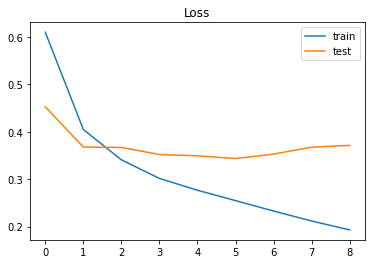

In [ ]:
# visualizing loss curves
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

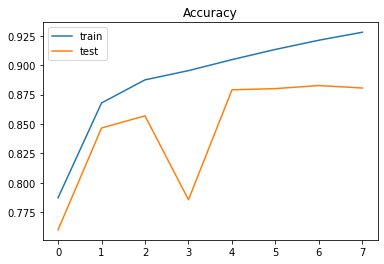

In [ ]:
# visualizing accuracy curves
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show();

## Stacked RNN

In [ ]:
stacked_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                              input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64, return_sequences=False),
    tf.keras.layers.Dense(5, activation='softmax')
])

stacked_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_12 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 simple_rnn_26 (SimpleRNN)   (None, 250, 64)           10560     
                                                                 
 simple_rnn_27 (SimpleRNN)   (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 5)                 325       
                                                                 
Total params: 5,019,141
Trainable params: 5,019,141
Non-trainable params: 0
____________________________________________

In [ ]:
stacked_rnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer='Nadam', metrics=["CategoricalAccuracy"])

In [ ]:
num_epochs = 10
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = stacked_rnn.fit(X_train, Y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])
                                                                    

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1003/1003 [==============================] - 435s 431ms/step - loss: 0.7256 - categorical_accuracy: 0.7344 - val_loss: 0.6726 - val_categorical_accuracy: 0.7513
Epoch 2/10
1003/1003 [==============================] - 430s 429ms/step - loss: 0.7455 - categorical_accuracy: 0.7273 - val_loss: 0.8441 - val_categorical_accuracy: 0.6837
Epoch 3/10
1003/1003 [==============================] - 431s 430ms/step - loss: 0.7222 - categorical_accuracy: 0.7408 - val_loss: 0.6169 - val_categorical_accuracy: 0.7804
Epoch 4/10
1003/1003 [==============================] - 464s 463ms/step - loss: 0.7612 - categorical_accuracy: 0.7228 - val_loss: 1.0097 - val_categorical_accuracy: 0.6156
Epoch 5/10
1003/1003 [==============================] - 431s 430ms/step - loss: 0.7151 - categorical_accuracy: 0.7322 - val_loss: 0.6773 - val_categorical_accuracy: 0.7443
Epoch 6/10
1003/1003 [==============================] - 430s 429ms/step - loss: 0.6690 - categorical_accuracy: 0.7584 - val_loss: 1.2854 - val_categori

In [ ]:
stacked_rnn.save('/content/drive/Shareddrives/NLP_Phase2/stacked_rnn')

In [ ]:
stacked_rnn_accr = stacked_rnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(stacked_rnn_accr[0],stacked_rnn_accr[1]))

495/495 [==============================] - 18s 36ms/step - loss: 1.2747 - categorical_accuracy: 0.6057
Test set
  Loss: 1.275
  Accuracy: 0.606


In [ ]:
history.history

{'loss': [0.7256025671958923,
  0.7454953789710999,
  0.722219705581665,
  0.7611852288246155,
  0.7151089906692505,
  0.668952465057373],
 'categorical_accuracy': [0.7343661189079285,
  0.727310299873352,
  0.7408371567726135,
  0.7227805256843567,
  0.7321519255638123,
  0.7583948373794556],
 'val_loss': [0.6726487874984741,
  0.844063937664032,
  0.616869330406189,
  1.0097240209579468,
  0.677341103553772,
  1.2853717803955078],
 'val_categorical_accuracy': [0.7513331174850464,
  0.683693528175354,
  0.7803816795349121,
  0.6155627369880676,
  0.744316577911377,
  0.6046870350837708]}

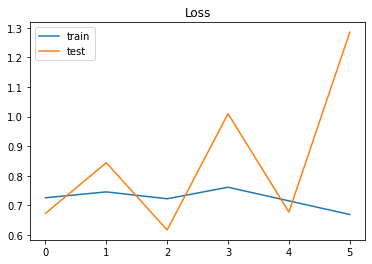

In [ ]:
# visualizing loss curves
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

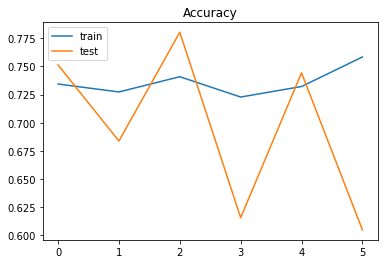

In [ ]:
# visualizing accuracy curves
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show();

## Transformer

In [ ]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = 20000  # Only consider the top 20k words
maxlen = 250  # Only consider the first 250 words of each complaint

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(5, activation="softmax")(x)

transformer = Model(inputs=inputs, outputs=outputs)

In [ ]:
transformer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250)]             0         
                                                                 
 token_and_position_embeddin  (None, 250, 32)          648000    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 250, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 32)                0   

In [ ]:
transformer.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer='Nadam', metrics=["CategoricalAccuracy"])
                   

In [ ]:
num_epochs = 10
batch_size = 128
history = transformer.fit(X_train, Y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])
                                                                    
                                             

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1003/1003 [==============================] - 23s 21ms/step - loss: 0.5681 - categorical_accuracy: 0.8017 - val_loss: 0.5545 - val_categorical_accuracy: 0.7797
Epoch 2/10
1003/1003 [==============================] - 21s 21ms/step - loss: 0.3731 - categorical_accuracy: 0.8725 - val_loss: 0.3722 - val_categorical_accuracy: 0.8708
Epoch 3/10
1003/1003 [==============================] - 21s 21ms/step - loss: 0.3377 - categorical_accuracy: 0.8847 - val_loss: 0.3704 - val_categorical_accuracy: 0.8727
Epoch 4/10
1003/1003 [==============================] - 21s 21ms/step - loss: 0.3116 - categorical_accuracy: 0.8928 - val_loss: 0.3684 - val_categorical_accuracy: 0.8745
Epoch 5/10
1003/1003 [==============================] - 21s 21ms/step - loss: 0.2882 - categorical_accuracy: 0.9004 - val_loss: 0.4008 - val_categorical_accuracy: 0.8687
Epoch 6/10
1003/1003 [==============================] - 21s 20ms/step - loss: 0.2660 - categorical_accuracy: 0.9084 - val_loss: 0.4085 - val_categorical_accuracy

In [ ]:
transformer.save('/content/drive/Shareddrives/NLP_Phase2/transformer')

In [ ]:
transformer = tf.keras.models.load_model('/content/drive/Shareddrives/NLP_Phase2/transformer')

In [ ]:
trans_accr = transformer.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(trans_accr[0],trans_accr[1]))

495/495 [==============================] - 3s 5ms/step - loss: 0.1597 - accuracy: 0.8662
Test set
  Loss: 0.160
  Accuracy: 0.866


In [ ]:
history.history

{'loss': [0.568124532699585,
  0.37311506271362305,
  0.3377480208873749,
  0.3116137385368347,
  0.28820472955703735,
  0.26604771614074707,
  0.24602532386779785],
 'categorical_accuracy': [0.8016887307167053,
  0.8725041747093201,
  0.8846822381019592,
  0.8927671909332275,
  0.9004155397415161,
  0.9084381461143494,
  0.9139814376831055],
 'val_loss': [0.5545328259468079,
  0.3722304105758667,
  0.3704463243484497,
  0.36842361092567444,
  0.40077775716781616,
  0.4084742069244385,
  0.42524823546409607],
 'val_categorical_accuracy': [0.779680073261261,
  0.8707549571990967,
  0.8727196455001831,
  0.8745439052581787,
  0.8687201738357544,
  0.861352801322937,
  0.8703339695930481]}

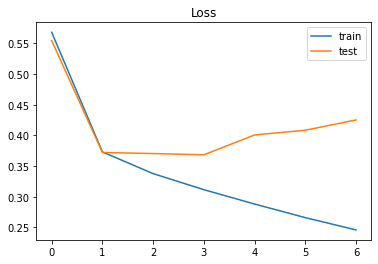

In [ ]:
# visualizing loss curves
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

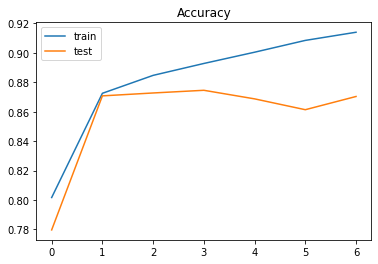

In [ ]:
# visualizing accuracy curves
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

## Stacked Feed Forward Neural Networks

In [ ]:
ffnn = Sequential([
    tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                              input_length=X.shape[1]),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(5, activation='softmax')
])

ffnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d_10 (Spati  (None, 250, 100)         0         
 alDropout1D)                                                    
                                                                 
 dense_22 (Dense)            (None, 250, 16)           1616      
                                                                 
 dense_23 (Dense)            (None, 250, 16)           272       
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense_24 (Dense)            (None, 5)                 20005     
                                                      

In [ ]:
ffnn.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer='Nadam', metrics=["CategoricalAccuracy"])

In [ ]:
num_epochs = 10
batch_size = 128
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = ffnn.fit(X_train, Y_train, 
                    epochs=num_epochs, batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])
                                                                    

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1003/1003 [==============================] - 8s 7ms/step - loss: 0.6139 - categorical_accuracy: 0.7816 - val_loss: 0.4782 - val_categorical_accuracy: 0.8414
Epoch 2/10
1003/1003 [==============================] - 7s 7ms/step - loss: 0.4155 - categorical_accuracy: 0.8615 - val_loss: 0.4362 - val_categorical_accuracy: 0.8532
Epoch 3/10
1003/1003 [==============================] - 7s 7ms/step - loss: 0.3661 - categorical_accuracy: 0.8776 - val_loss: 0.4347 - val_categorical_accuracy: 0.8564
Epoch 4/10
1003/1003 [==============================] - 7s 7ms/step - loss: 0.3329 - categorical_accuracy: 0.8884 - val_loss: 0.4452 - val_categorical_accuracy: 0.8549
Epoch 5/10
1003/1003 [==============================] - 7s 7ms/step - loss: 0.3050 - categorical_accuracy: 0.8978 - val_loss: 0.4409 - val_categorical_accuracy: 0.8586
Epoch 6/10
1003/1003 [==============================] - 7s 7ms/step - loss: 0.2819 - categorical_accuracy: 0.9068 - val_loss: 0.4585 - val_categorical_accuracy: 0.8577


In [ ]:
ffnn.save('/content/drive/Shareddrives/NLP_Phase2/ffnn')

In [ ]:
ffnn_accr = ffnn.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(ffnn_accr[0],ffnn_accr[1]))

495/495 [==============================] - 2s 3ms/step - loss: 0.4711 - categorical_accuracy: 0.8596
Test set
  Loss: 0.471
  Accuracy: 0.860


In [ ]:
history.history

{'loss': [0.6138759851455688,
  0.4154619574546814,
  0.3661423921585083,
  0.33290719985961914,
  0.30497369170188904,
  0.2818720042705536],
 'categorical_accuracy': [0.7816050052642822,
  0.861542284488678,
  0.8776342272758484,
  0.8883699774742126,
  0.8978427052497864,
  0.9068086743354797],
 'val_loss': [0.4782101511955261,
  0.4361855983734131,
  0.4346805512905121,
  0.4451931416988373,
  0.44092991948127747,
  0.4584752023220062],
 'val_categorical_accuracy': [0.8414257764816284,
  0.8532136082649231,
  0.8564411997795105,
  0.8548975586891174,
  0.8586163520812988,
  0.8577041625976562]}

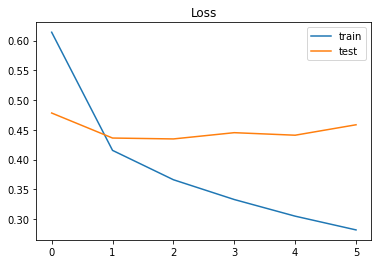

In [ ]:
# visualizing loss curves
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

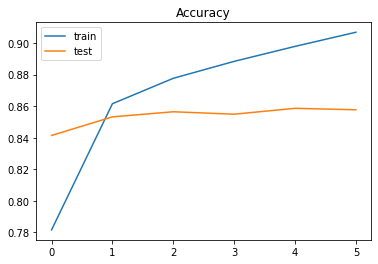

In [ ]:
# visualizing accuracy curves
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.plot(history.history['val_categorical_accuracy'], label='test')
plt.legend()
plt.show()

## Best Model Prediction on Test Data

**Since Stacked LSTM has the highest accuracy of 0.88 on the validation set, it performs the best among other implemented models. So, we will predict the class labels of consumer complaints of test set using Stacked LSTM model.**

In [ ]:
# Stacked LSTM
best_model = tf.keras.models.load_model('/content/drive/Shareddrives/NLP_Phase2/lstm')

In [ ]:
# Pre-Processing test data

#The maximum number of words to be used
MAX_NB_WORDS = 50000
# Maximum number of words in each complaint
MAX_SEQUENCE_LENGTH = 250

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                      lower=True)
tokenizer.fit_on_texts(tst_data['Complaints'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9757 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(tst_data['Complaints'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4061, 250)


In [ ]:
# predicting class labels

labels = ['credit_card',
 'credit_reporting',
 'debt_collection',
 'mortgages_and_loans',
 'retail_banking']
prediction_label=[]
i=0
for i in X:
    prediction = lstm.predict(np.array([i]))
    prediction_label.append(labels[np.argmax(prediction[0])])
    i += 1

1/1 [==============================] - 0s 68ms/step


In [ ]:
# storing predicted class labels in csv file
df=pd.DataFrame(prediction_label)

In [ ]:
df.to_csv('/content/drive/Shareddrives/NLP_Phase2/Predicted.csv', header=None, index=False)